In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import train_test

from sklearn.metrics.pairwise import cosine_similarity

In [71]:
rating_df = pd.read_csv('data/user_rating.csv')
R = np.array(rating_df)

In [72]:
R

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [203]:
known = []
for u in range(R.shape[0]):
    for i in range(R.shape[1]):
        if R[u,i] > 0:
            known.append((u, i))
            
training, testing = train_test(known)

In [207]:
KNN_user_results = {'K':[], 'RMSE':[]}

In [231]:
k=200

unique_users = []
for u, i in testing:
    if u not in unique_users:
        unique_users.append(u)

R_copy = R.copy()
for u, i in testing:
    R_copy[u, i] = 0        
    
avg_user_rating = []
for u in range(R_copy.shape[0]):
    user_mean = R_copy[u,:][R_copy[u,:] > 0].mean()
    avg_user_rating.append(user_mean)    

cos_sim = cosine_similarity(R_copy)
np.fill_diagonal(cos_sim, 0)    

top_sim = {}
for user in unique_users:
    args = np.argpartition(-cos_sim[user], k)
    top_sim[user] = {'similarities':cos_sim[user][args[:k]], 'args':args[:k]}

predict_ratings = []
for u, i in testing:
    args = top_sim[u]['args']
    sim_values = top_sim[u]['similarities']
    
    ratings = np.array([])
    similarities = np.array([])
    sim_user_index = np.array([])
    
    for user, sim in zip(args, sim_values):
        if R_copy[user, i] != 0:
            ratings = np.append(ratings, R_copy[user, i])
            similarities = np.append(similarities, sim)
            sim_user_index = np.append(sim_user_index, user)
    
    
    sim_sum = 0
    predict = avg_user_rating[u]
    
    if len(ratings) > 0:
        for ind, user in enumerate(sim_user_index.astype(int)):
            sim_sum += similarities[ind]*(avg_user_rating[user] - avg_user_rating[u])
            
        predict += (1/sum(similarities))*sim_sum
    else:
        predict = 0
        
    predict_ratings.append(predict)

In [232]:
total = 0
num_rated = 0

for i in range(len(testing)):
    if predict_ratings[i] != 0:
        total += (R[testing[i]] - predict_ratings[i])**2
        num_rated+=1
        
KNN_user_results['K'].append(k)
KNN_user_results['RMSE'].append((total/num_rated)**.5)

In [233]:
KNN_user_df = pd.DataFrame(KNN_user_results)
KNN_user_df

,K,RMSE
0,5,1.016112
1,10,1.019211
2,15,1.014429
3,25,1.013422
4,50,1.012270
5,75,1.012403
6,100,1.011807
7,150,1.010139
8,200,1.010480


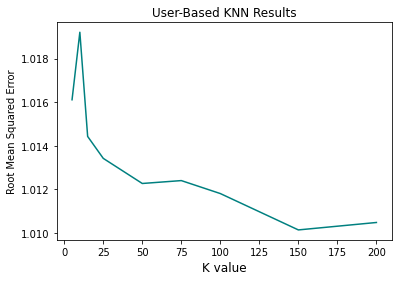

In [294]:
plt.plot(KNN_user_df['K'], KNN_user_df['RMSE'], color='teal')

plt.title('User-Based KNN Results')
plt.xlabel('K value', size=12)
plt.ylabel('Root Mean Squared Error')

plt.savefig('graphs/KNN_user.png')

plt.show()

In [29]:
total = 0
num_rated = 0

for i in range(len(testing)):
    if predict_ratings[i] != 0:
        total += (R[testing[i]] - predict_ratings[i])**2
        num_rated+=1

In [30]:
(total/num_rated)**.5

1.0158952550842248

In [256]:
KNN_item_results = {'K':[], 'RMSE':[]}

In [287]:
k=1500

unique_items = []
for u, i in testing:
    if i not in unique_items:
        unique_items.append(i)

R_copy = R.copy()
for u, i in testing:
    R_copy[u, i] = 0        
    
avg_user_rating = []
for u in range(R_copy.shape[0]):
    user_mean = R_copy[u,:][R_copy[u,:] > 0].mean()
    avg_user_rating.append(user_mean)    

cos_sim = cosine_similarity(R_copy.T)
np.fill_diagonal(cos_sim, 0)    

top_sim = {}
for item in unique_items:
    args = np.argpartition(-cos_sim[item], k)
    top_sim[item] = {'similarities':cos_sim[item][args[:k]], 'args':args[:k]}

predict_ratings = []
for u, i in testing:
    args = top_sim[i]['args']
    sim_values = top_sim[i]['similarities']
    
    ratings = np.array([])
    similarities = np.array([])
    sim_item_index = np.array([])
    
    for item, sim in zip(args, sim_values):
        if R_copy[u, item] != 0:
            ratings = np.append(ratings, R_copy[u, item])
            similarities = np.append(similarities, sim)
    
    sim_sum = 0
    predict = avg_user_rating[u]
    if (len(ratings) > 0) and (sum(similarities)>0):
        predict = sum(similarities*ratings)/sum(similarities)
        
    predict_ratings.append(predict)

In [288]:
total = 0
num_rated = 0

for i in range(len(testing)):
    if predict_ratings[i] != 0:
        total += (R[testing[i]] - predict_ratings[i])**2
        num_rated+=1
        
KNN_item_results['K'].append(k)
KNN_item_results['RMSE'].append((total/num_rated)**.5)

In [289]:
KNN_item_df = pd.DataFrame(KNN_item_results)
KNN_item_df

,K,RMSE
0,5,0.958991
1,25,0.928311
2,50,0.916762
3,100,0.902241
4,150,0.900540
5,250,0.897114
6,350,0.895210
7,500,0.889785
8,750,0.890082
9,1000,0.892950


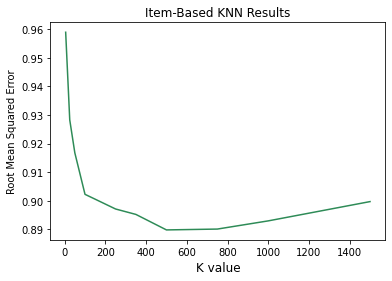

In [293]:
plt.plot(KNN_item_df['K'], KNN_item_df['RMSE'], color='seagreen')

plt.title('Item-Based KNN Results')
plt.xlabel('K value', size=12)
plt.ylabel('Root Mean Squared Error')

plt.savefig('graphs/KNN_item.png')

plt.show()